## Model Improvement Suggentions

**1:** Test different methods for each model pipeline steps

**1.1:** Try different Model
- Current Model: all-mpnet-base-v2
- [Hugging Face - Model leaderboard:](https://huggingface.co/spaces/mteb/leaderboard) (Try at least 3 best ones)

**1.2:** Try skill-by-skill vs. bag-of-skills

**1.3:** ...

**2:** Last Step: Cross-Encoder without and with special tokens (new approach)

## 1 Running the Analysis on the Baseline Model

### 1.1 Import the Synthetic Dataset

In [2]:
import pandas as pd

# Import the CSV file into a dataframe
file_path = "/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo/synthetic_data_csv/df_synth_data.csv"
df_synth_data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify the import
df_synth_data

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0
...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0


### 1.2 Baseline Model Performance

In [19]:
import sys
import os
import pandas as pd
from spacy.lang.en import English

# Define project root paths
PROJECT_ROOT = '/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo'
SERVICES_DIR = os.path.join(PROJECT_ROOT, 'services')
RESOURCES_DIR = os.path.join(PROJECT_ROOT, 'Resources', 'data')

# Add the paths to sys.path if not already present
for module_path in [SERVICES_DIR, PROJECT_ROOT]:
    if module_path not in sys.path:
        sys.path.append(module_path)

# Import the necessary classes and functions
from JobInfoExtraction import JobInfoExtraction
from ResumeInfoExtraction import ResumeInfoExtraction
from main import calc_similarity

# Define the path to your skills patterns file
skills_patterns_path = os.path.join(RESOURCES_DIR, 'skills.jsonl')

# Instantiate the JobInfoExtraction and ResumeInfoExtraction classes
jie = JobInfoExtraction(skills_patterns_path)
rie = ResumeInfoExtraction(skills_patterns_path, name="Default Resume Info Extractor")

In [20]:
import time
import pandas as pd

def main_synth_df():
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in df_synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = df_synth_data[df_synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = jie.extract_entities(df_jobs)  # Use jie to extract job description skills
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()
        resumes['raw'] = resumes['CV_text']  # Rename for consistency with extraction method
        df_resumes = rie.extract_entities(resumes)  # Use rie to extract resume skills
        
        # Ensure `name` column exists for calc_similarity
        df_resumes['name'] = df_resumes['CV_ID']  # Use CV_ID as the `name` column
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity(df_resumes, df_jobs, parallel=True)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['similarity_score']  # Assuming calc_similarity outputs this

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

# Run the function
df_result = main_synth_df()

Processing Time: 219441.12ms


In [21]:
df_result

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1,0.889664
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1,0.909190
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1,0.917873
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0,0.840666
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0,0.825386
...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1,0.948920
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1,0.924166
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0,0.786664
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0,0.833034


In [22]:
import sys
import os
import pandas as pd
from spacy.lang.en import English

# Define project root paths
PROJECT_ROOT = '/Users/timg/Desktop/Workproject/my_fork/workproject_matching_algo'
SERVICES_DIR = os.path.join(PROJECT_ROOT, 'services')
RESOURCES_DIR = os.path.join(PROJECT_ROOT, 'Resources', 'data')

# Add the paths to sys.path if not already present
for module_path in [SERVICES_DIR, PROJECT_ROOT]:
    if module_path not in sys.path:
        sys.path.append(module_path)

# Import the necessary functions
from main import calc_similarity, job_info_extraction, resume_extraction  # Import the necessary functions

# Define the path to your skills patterns file
skills_patterns_path = os.path.join(RESOURCES_DIR, 'skills.jsonl')

In [24]:
import time
import pandas as pd

def main_synth_df():
    t0 = time.time()

    # Initialize an empty list to store results
    similarity_results = []

    # Iterate over each unique job description ID in the dataset
    for jd_id in df_synth_data['JD_ID'].unique():
        # Filter the data for the current job description
        job_data = df_synth_data[df_synth_data['JD_ID'] == jd_id]

        # Extract the job description text
        jd_text = job_data.iloc[0]['JD_text']
        df_jobs = pd.DataFrame([jd_text], columns=["raw"])
        df_jobs = job_info_extraction(df_jobs)  # Use job_info_extraction to extract job description skills
        
        # Extract resumes for this job description
        resumes = job_data[['CV_ID', 'CV_text']].copy()  # Include necessary columns
        resumes['name'] = resumes['CV_ID']  # Add a "name" column derived from CV_ID for compatibility
        resumes['raw'] = resumes['CV_text']  # Add a "raw" column for compatibility
        df_resumes = resume_extraction(resumes)  # Use resume_extraction to extract resume skills
        
        # Calculate similarity for the job description and its related resumes
        analysis_data_df = calc_similarity(df_resumes, df_jobs, parallel=True)
        
        # Add similarity scores back to the original data
        job_data = job_data.reset_index(drop=True)
        job_data['Similarity_score'] = analysis_data_df['similarity_score']  # Assuming calc_similarity outputs this

        # Append to results
        similarity_results.append(job_data)

    # Combine all results into a single DataFrame
    df_final = pd.concat(similarity_results, ignore_index=True)

    t1 = time.time()
    dt = t1 - t0
    print(f"Processing Time: {dt*1000:.2f}ms")
    
    return df_final

# Run the function
df_result = main_synth_df()

Processing Time: 241135.15ms


In [25]:
df_result

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1,0.889664
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1,0.909190
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1,0.917873
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0,0.840666
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0,0.825386
...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1,0.948920
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1,0.924166
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0,0.786664
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0,0.833034


In [26]:
# Add a new column 'label_predicted' where top 3 resumes = 1 and the rest = 0
df_result = df_result.sort_values(['JD_ID', 'Similarity_score'], ascending=[True, False])

# Apply the labeling logic within each JD_ID group
df_result['label_predicted'] = df_result.groupby('JD_ID')['Similarity_score'].rank(ascending=False).apply(lambda x: 1 if x <= 3 else 0)

# Display the updated DataFrame
df_result

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
2,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,13,**John D. Anderson** \n123 Tech Lane \nSan F...,1,0.917873,1
1,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,12,**John Smith** \n[LinkedIn Profile] | [Github...,1,0.909190,1
0,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,11,"**John Doe** \n123 Tech Lane \nPleasanton, C...",1,0.889664,1
3,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,14,**John Anderson** \n123 Tech Avenue \nPleasa...,0,0.840666,0
4,1,Senior Site Reliability Engineer,About the Team Workday is building a new SRE t...,15,**John Smith** \n123 Tech Lane \nSan Francis...,0,0.825386,0
...,...,...,...,...,...,...,...,...
595,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1002,"**John Smith** \n123 Tech Drive \nSan Jose, ...",1,0.948920,1
596,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1003,**Resume**\n\n**John Doe** \n123 Main Street ...,1,0.924166,1
598,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1005,"**John Doe** \n1234 Elm Street \nCityville, ...",0,0.833034,0
597,100,Software Engineer,"Why APCON? At APCON, we are committed to setti...",1004,"**John Doe** \n[Your Address] \n[City, State...",0,0.786664,0


In [27]:
df_result["label_predicted"].value_counts()

label_predicted
1    300
0    300
Name: count, dtype: int64

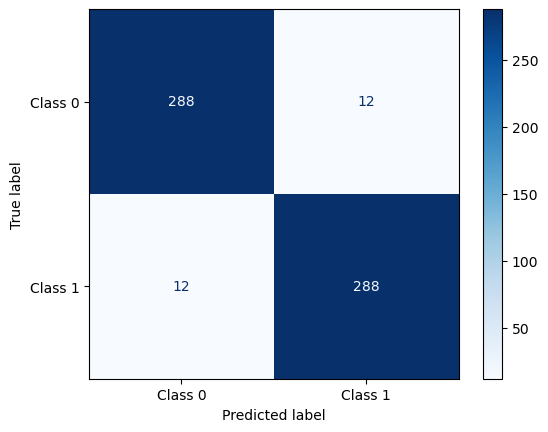

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(df_result['label'], df_result['label_predicted'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap="Blues", values_format="d")

In [35]:
# Filter the rows where "label" and "label_predicted" do not match
df_mismatched = df_result[df_result['label'] != df_result['label_predicted']]

# Display the filtered DataFrame
df_mismatched.head()

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
111,19,Machine Learning Engineer,a Bit About Us 🧑‍💻 Quinn started as a dream ou...,194,"**Jane Doe** \nSeattle, WA | (555) 123-4567 |...",0,0.859943,1
109,19,Machine Learning Engineer,a Bit About Us 🧑‍💻 Quinn started as a dream ou...,192,"**Alex Thompson** \n[Your Address] \n[City, ...",1,0.781876,0
159,27,Software Engineer,Facebook's mission is to give people the power...,274,"**Jane Smith** \n[Your Address] \n[City, Sta...",0,0.797087,1


In [32]:
# Identify JD_IDs with mismatched rows
mismatched_jd_ids = df_result.loc[df_result['label'] != df_result['label_predicted'], 'JD_ID'].unique()

# Filter the DataFrame to include only rows with these JD_IDs
df_mismatched_jd_ids = df_result[df_result['JD_ID'].isin(mismatched_jd_ids)]

# Display the filtered DataFrame
df_mismatched_jd_ids.head(6)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,"**John Doe** \n[Your Address] \n[City, State...",1,0.935291,1
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John D. Smith** \n[Your Address] \n[City, ...",1,0.897163,1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
11,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,26,**Resume**\n\n**Johnathan Smith**\n123 Elm Str...,0,0.865572,0
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
10,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,**Resume of Alex Johnson** \n[Alex.Johnson@em...,0,0.815020,0


In [34]:
# Sort the DataFrame by JD_ID and Similarity_score
df_mismatched_jd_ids = df_mismatched_jd_ids.sort_values(by=['JD_ID', 'Similarity_score'], ascending=[True, False])

# Display the sorted DataFrame
df_mismatched_jd_ids.head(6)

,JD_ID,JD_title,JD_text,CV_ID,CV_text,label,Similarity_score,label_predicted
8,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,23,"**John Doe** \n[Your Address] \n[City, State...",1,0.935291,1
6,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,21,"**John D. Smith** \n[Your Address] \n[City, ...",1,0.897163,1
9,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,24,**Resume**\n\n**John Smith** \n123 Tech Lane ...,0,0.878676,1
11,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,26,**Resume**\n\n**Johnathan Smith**\n123 Elm Str...,0,0.865572,0
7,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,22,"**Jessica M. Anderson** \nDenver, CO 80202 \...",1,0.850653,0
10,2,Front End Cloud Software Developer,Candidate Requirements Must be physically loca...,25,**Resume of Alex Johnson** \n[Alex.Johnson@em...,0,0.815020,0
